# TRABAJO PRÁCTICO 6 - PCA

In [527]:
# Librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Audio
import librosa
import IPython.display as ipd

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Regresion Logistica
from sklearn.linear_model import LogisticRegression

# LDA y QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# KNN
from sklearn.neighbors import KNeighborsClassifier

# SVM
from sklearn.svm import SVC

# Arboles de decision
from sklearn.tree import DecisionTreeClassifier

# Metricas
from sklearn.metrics import accuracy_score, f1_score

# PCA
from sklearn.decomposition import PCA


# Preprocesamiento de datos

### Funciones

In [528]:
# Esta función recorta los audios dados, asumiento el mismo sampling rate
# audios debe ser una lista
# Retorna un array con los datos con la misma cantidad de muestras
def cut_audios (init_sec, duration, audios, sr):
    n_audios = len(audios)

    samples_init_sec = init_sec * sr 
    samples_final_sec = init_sec * sr + duration * sr

    #Se genera una lista con los audios recortados usando list comprehension
    data=[audios [i] [ samples_init_sec : samples_final_sec ] for i in range(n_audios)]

    return np.array(data)

# Esta función calcula las fft para los elementos de data y los escala en dB.
# Se usan los mismos parametros para todas las fft
def stft (data, n_fft, win_length, hop_length, window):

    n_data = data.shape[0]

    #Se genera una lista con las STFT de los audios
    D= [librosa.stft(data[i], n_fft=n_fft, hop_length=hop_length , win_length=win_length, window=window) for i in range(n_data)]

    #Se escalan a dB los datos de la fft
    #Cada elemento de S_db tiene dimensiones: (freq, frames)
    S_db = [ librosa.amplitude_to_db(np.abs(D[i]), ref=np.max) for i in range(n_data) ] 

    # print('[freq, frames]:', S_db[0].shape) 

    return np.array(S_db)

# Esta función genera los datasets a partir de los datos escalados en dB (esto último no es necesario, funciona igual con los datos sin escalar)
def build_dataset(S_db):
    
    x = []
    y = []

    for i in range(1,len(S_db)+1) :
        x.append(S_db[i-1].T) #Se cargan los datos como (frames , freq)
        y.append(np.full(S_db[i-1].shape[1], i)) #Se utiliza el indice 1 y 2 para la etiqueta de los frames

    x = np.array(x)
    y = np.array(y)

    # print('shapes de x:',x.shape)
    # print('shapes de y', y.shape)

    x = np.vstack(x) #Se apilan las matrices de la stft de cada audio (axis = 0)
    y = np.concatenate(y,axis = 0) #Se concatenan las filas de las etiquetas de los frames

    # print('shapes de x apilados verticalmente:',x.shape)
    # print('shapes de y concatenados: ', y.shape)

    return x,y


#Esta función realiza la rutina completa de generación del dataset
def generate_dataset (init_sec, duration, audios, sr) : 

    data = cut_audios(init_sec, duration, audios, sr)

    n_fft = 2048
    win_length = n_fft
    hop_length = int(win_length*0.25) #75% de solapamiento
    window = 'hann'

    S_db = stft(data, n_fft=n_fft, win_length=win_length , hop_length=hop_length, window=window)

    x, y = build_dataset(S_db)

    return x, y

### Carga de los datos y gráficos temporales

sr[0]: 22050
shape del audio 0  (3463512,)
sr[1]: 22050
shape del audio 1  (2659230,)


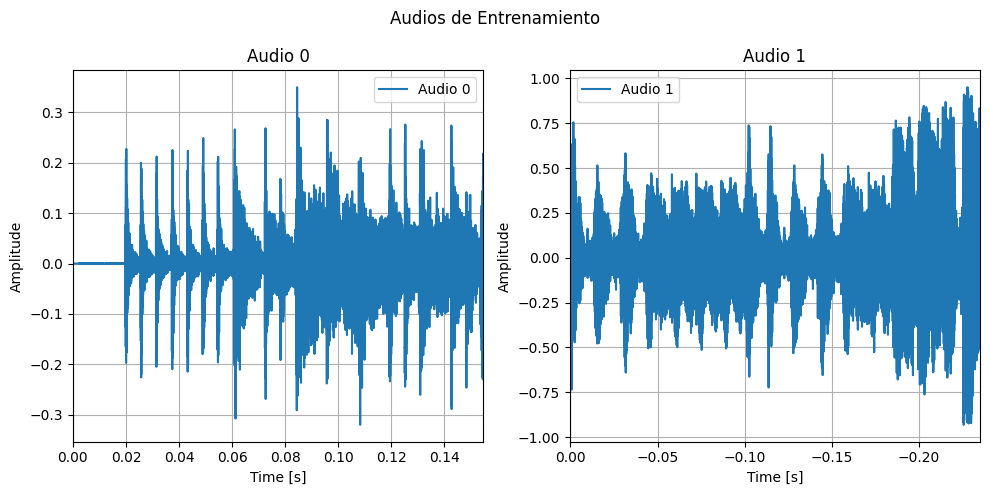

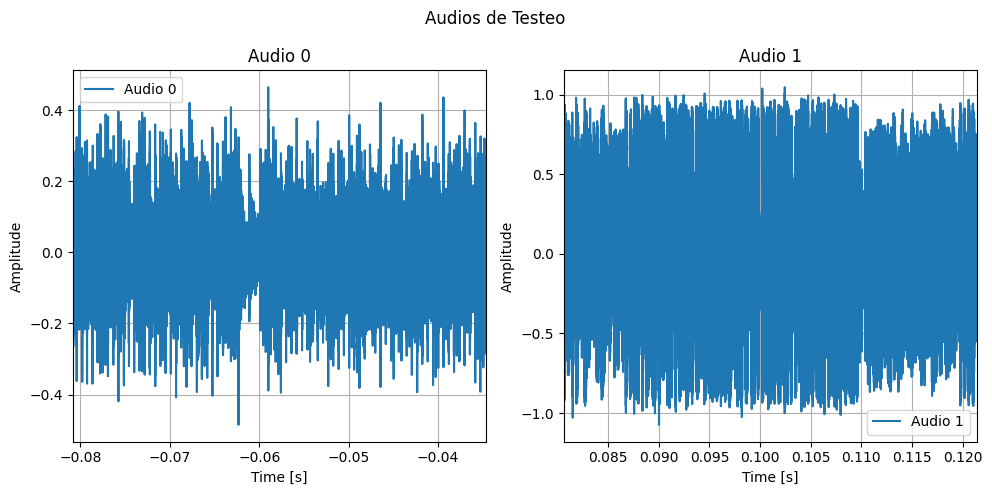

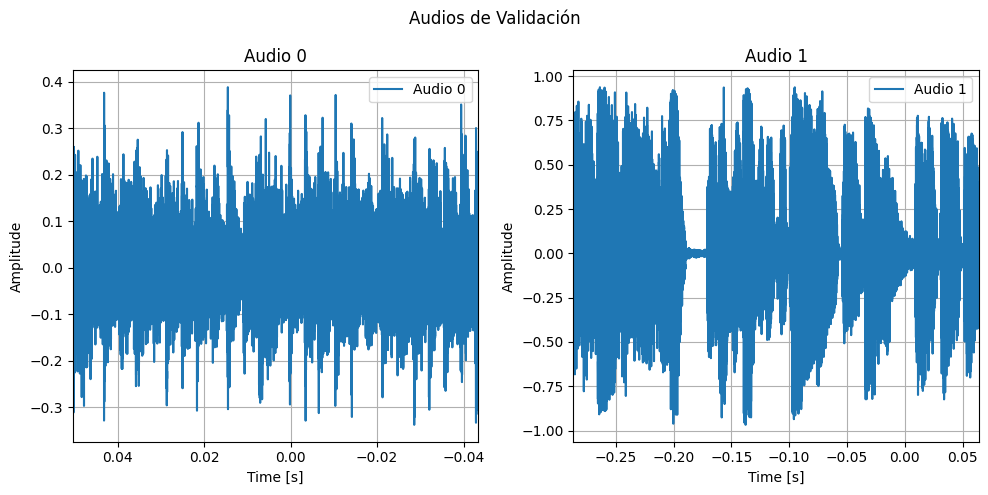

In [529]:
filename1 = 'mi_perro_dinamita.mp3'
filename2 = 'exclusive.mp3'

files = [filename1,filename2]

#-------------------------------------------------- Se cargan los audios completos
audios = []
sr = []

for i in range(len(files)):
    y, r = librosa.load (files[i])
    audios.append(y)
    sr.append(r)

for i in range(len(audios)):
    print(f'sr[{i}]:',sr[i])
    print(f'shape del audio {i} ', audios[i].shape)

#-------------------------------------------------- Se recortan los audios

init_sec_train = 0 
init_sec_test = 60
init_sec_val = 30 

duration_train = 5
duration_test = 30
duration_val = 5

sr = sr[0] #Tienen el mismo sampling rate

data_train = cut_audios(audios = audios, init_sec= init_sec_train, duration= duration_train, sr = sr)
data_test = cut_audios(audios = audios, init_sec= init_sec_test, duration= duration_test, sr = sr)
data_val = cut_audios(audios = audios, init_sec= init_sec_val, duration= duration_val, sr = sr)

# for i in range(data_train.shape[0]):
#     print(f'shape data[{i}] con 5 seg',data_train[i].shape)


#-------------------------------------------------- Se generan las listas de tiempo

times_train = [np.linspace ( data_train[i][0], data_train[i][-1], data_train[i].shape[0] ) for i in range(data_train.shape[0])]

times_test = [np.linspace ( data_test[i][0], data_test[i][-1], data_test[i].shape[0] ) for i in range(data_test.shape[0])]

times_val = [np.linspace ( data_val[i][0], data_val[i][-1], data_val[i].shape[0] ) for i in range(data_val.shape[0])]


#-------------------------------------------------- Se grafican los audios

#Graficos de entrenamiento
fig,axes = plt.subplots(1,2,figsize = (10,5))
axes = axes.flatten()
fig.suptitle('Audios de Entrenamiento')

for i in range (data_train.shape[0]):
    axes[i].plot(times_train[i],data_train[i],label=f'Audio {i}')
    axes[i].set_xlabel('Time [s]' )
    axes[i].set_ylabel('Amplitude')
    axes[i].set_xlim(times_train[i][0],times_train[i][-1])
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title(f'Audio {i}')

plt.tight_layout()


#Graficos de testeo
fig,axes = plt.subplots(1,2,figsize = (10,5))
axes = axes.flatten()
fig.suptitle('Audios de Testeo')

for i in range (data_test.shape[0]):
    axes[i].plot(times_test[i],data_test[i],label=f'Audio {i}')
    axes[i].set_xlabel('Time [s]' )
    axes[i].set_ylabel('Amplitude')
    axes[i].set_xlim(times_test[i][0],times_test[i][-1])
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title(f'Audio {i}')

plt.tight_layout()


#Graficos de validacion
fig,axes = plt.subplots(1,2,figsize = (10,5))
axes = axes.flatten()
fig.suptitle('Audios de Validación')

for i in range (data_val.shape[0]):
    axes[i].plot(times_val[i],data_val[i],label=f'Audio {i}')
    axes[i].set_xlabel('Time [s]' )
    axes[i].set_ylabel('Amplitude')
    axes[i].set_xlim(times_val[i][0],times_val[i][-1])
    axes[i].legend()
    axes[i].grid()
    axes[i].set_title(f'Audio {i}')

plt.tight_layout()

### Reproducción del audio

In [530]:
# ipd.Audio(data1, rate = sr)
# ipd.Audio(data2, rate = sr)

### Espectrogramas

shape de S_db_train[0] (1025, 216)
shape de S_db_train[1] (1025, 216)
shape de S_db_test[0] (1025, 1292)
shape de S_db_test[1] (1025, 1292)
shape de S_db_val[0] (1025, 216)
shape de S_db_val[1] (1025, 216)


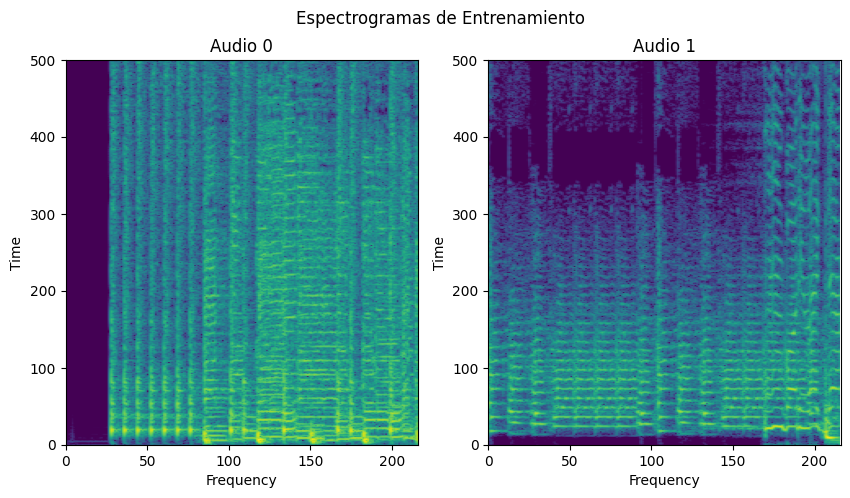

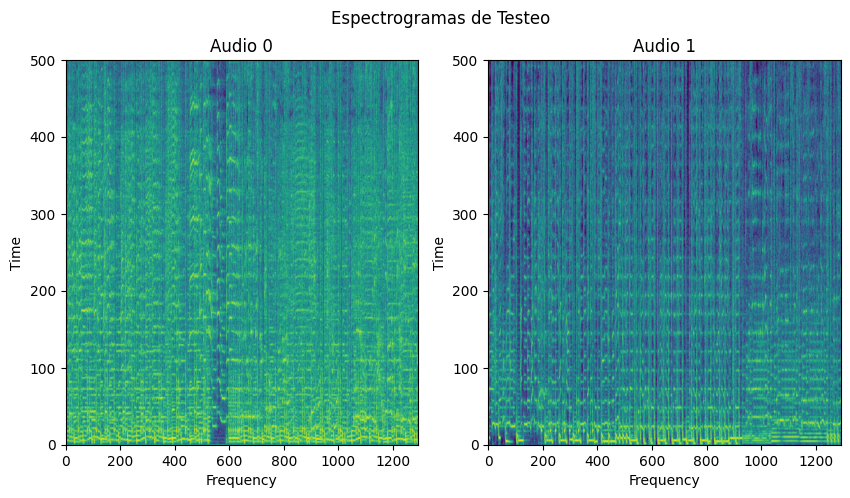

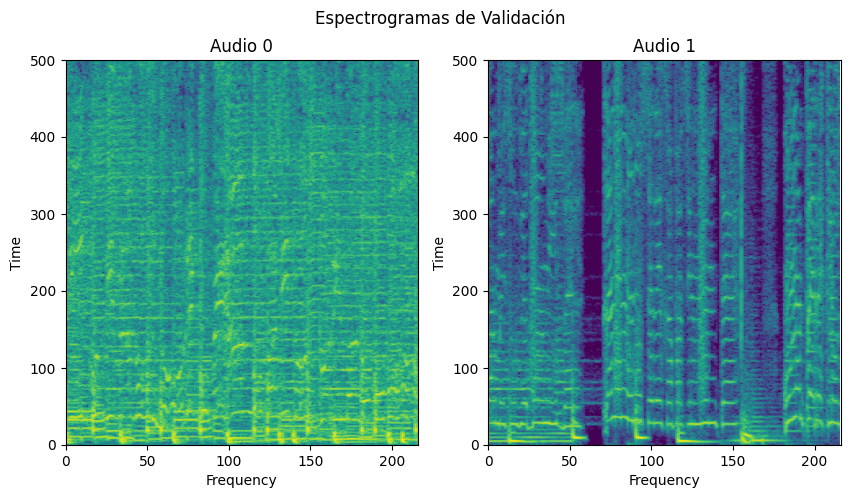

In [531]:
#------------------------------------------------------ Se calculan las FFT

n_fft = 2048
win_length = n_fft
hop_length = int(win_length*0.25) #75% de solapamiento
window = 'hann'

S_db_train = stft (data = data_train, n_fft = n_fft, win_length = win_length, hop_length = hop_length, window = window)
S_db_test = stft (data = data_test, n_fft = n_fft, win_length = win_length, hop_length = hop_length, window = window)
S_db_val = stft (data = data_val, n_fft = n_fft, win_length = win_length, hop_length = hop_length, window = window)

#Cada elemento de S_db tiene dimensiones: (freq, frames)
for i in range(S_db_train.shape[0]):
    print(f'shape de S_db_train[{i}]',S_db_train[i].shape)

for i in range(S_db_test.shape[0]):
    print(f'shape de S_db_test[{i}]',S_db_test[i].shape)

for i in range(S_db_val.shape[0]):
    print(f'shape de S_db_val[{i}]',S_db_val[i].shape)
    

#------------------------------------------------------ Se grafican los espectrogramas de Train, Test y Validation

#Espectrogramas de Entrenamiento
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
fig.suptitle('Espectrogramas de Entrenamiento')

for i in range(S_db_train.shape[0]) :
    axes[i].imshow(S_db_train[i],aspect = 'auto')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Time')
    axes[i].set_xlim(0,216)
    axes[i].set_ylim(0,500)
    axes[i].set_title(f'Audio {i}')


#Espectrogramas de Testeo
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
fig.suptitle('Espectrogramas de Testeo')

for i in range(S_db_test.shape[0]) :
    axes[i].imshow(S_db_test[i],aspect = 'auto')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Time')
    axes[i].set_xlim(0,1292)
    axes[i].set_ylim(0,500)
    axes[i].set_title(f'Audio {i}')


#Espectrogramas de Validacion
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
fig.suptitle('Espectrogramas de Validación')

for i in range(S_db_val.shape[0]) :
    axes[i].imshow(S_db_val[i],aspect = 'auto')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Time')
    axes[i].set_xlim(0,216)
    axes[i].set_ylim(0,500)
    axes[i].set_title(f'Audio {i}')



### Generación de datasets de entrenamiento, testeo y validacion

In [532]:
init_sec_train = 0 
init_sec_test = 60
init_sec_val = 30 

duration_train = 5
duration_test = 30
duration_val = 5

x_train, y_train = generate_dataset(init_sec=init_sec_train, duration=duration_train, audios= audios, sr= sr )

x_test, y_test = generate_dataset(init_sec=init_sec_test, duration=duration_test, audios= audios, sr= sr )

x_val, y_val = generate_dataset(init_sec=init_sec_val, duration=duration_val, audios= audios, sr=sr)


# Aprendizaje supervisado

## Escalado

In [533]:
#Se crea el scaler
scaler = StandardScaler()

#Se entrena el scaler con los datos de entrenamiento
scaler.fit(x_train)

#Se aplica el escalado a los datos
x_train_scaled = scaler.transform(x_train)
x_val_scaled   = scaler.transform(x_val)
x_test_scaled  = scaler.transform(x_test)

## Regresión Logística

In [534]:
#Se define el modelo: Stochastic Gradient Descent
#Dicho modelo es mejor cuando hay muchas features, como en este caso, donde hay muchos frames
#Se decide utilizar la log-loss como función de costos
log_reg = LogisticRegression(
    penalty='l2',
    C=0.5, #Se controla la "fuerza" de regularización
    solver='lbfgs',
    max_iter=1000,
    random_state=509
)

#Se entrena el modelo
log_reg.fit(x_train_scaled,y_train) #Datos escalados

#Se realizan las predicciones de testeo y validación
y_pred_test = log_reg.predict(x_test_scaled)
y_pred_val = log_reg.predict(x_val_scaled)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.6780185758513931
Accuracy de validación: 0.625


## LDA/QDA

#### LDA

In [535]:
#Se define el modelo LDA
#Se selecciona 'SVD' como solver ya que maximiza el accuracy de validación. Además, este método es ideal cuando se tienen muchas features
lda = LDA(solver='svd')

#Se entrena el modelo
lda.fit(x_train_scaled, y_train)    #Datos escalados

#Se realizan las predicciones de testeo y validación
y_pred_test = lda.predict(x_test_scaled)
y_pred_val = lda.predict(x_val_scaled)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.6211300309597523
Accuracy de validación: 0.6597222222222222


#### QDA

In [536]:
#Se define el modelo QDA.
#Se selecciona reg_param para maximizar el accuracy de validación.
#reg_param regulariza la covarianza de cada clase. Se utiliza ya que las covarianzas están mal condicionadas (se indica mediante un warning)
qda = QDA(reg_param=0.04)

#Se entrena el modelo
qda.fit(x_train_scaled, y_train) #Datos escalados

#Se realizan las predicciones de testeo y validación
y_pred_test = qda.predict(x_test_scaled)
y_pred_val = qda.predict(x_val_scaled)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.8521671826625387
Accuracy de validación: 0.8958333333333334


c:\Users\solek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\solek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(



## KNN

In [537]:
#Se define el modelo KNN
#Dado que los datos son ruidosos, se utiliza Manhattan para eliminar sensibilidad a outliers y optimiza el accuracy
#Euclidean es una buena métrica también dado que los datos son continuos
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

#Se entrena el modelo
knn.fit(x_train_scaled, y_train)

#Se realizan las predicciones de testeo y validación
y_pred_test = knn.predict(x_test_scaled)
y_pred_val = knn.predict(x_val_scaled)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.6753095975232198
Accuracy de validación: 0.6712962962962963


## SVM

In [538]:
#Se define el modelo SVM
#Se selecciona el kernel 'rbf'. Se seleccionan C y gamma tal que se optimice el accuracy y evitar un overfitting
svm = SVC(kernel='rbf', C=3, gamma = 'auto')  

#Se entrena el modelo
svm.fit(x_train_scaled, y_train)

#Se realizan las predicciones de testeo y validación
y_pred_test = svm.predict(x_test_scaled)
y_pred_val = svm.predict(x_val_scaled)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.7813467492260062
Accuracy de validación: 0.7708333333333334


## Árboles de decisión

In [539]:
#Se define el árbol de decisión
#Se selecciona el criterio de entropia para el árbol, ya que maximiza el accuracy
tree = DecisionTreeClassifier(
    criterion = 'entropy',
    random_state=509
)

#Se entrena el modelo
tree.fit(x_train, y_train)

#------------ Se obtienen los alpha que maximizan el accuracy de validación y se reentrena el modelo

#Se obtienen los alpha posibles
path = tree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas

#Se obtiene la lista de los accuracy de validación para cada alpha
accuracy = []
for alpha in ccp_alphas:
    tree_it = DecisionTreeClassifier(criterion='entropy',
                                  random_state=509,
                                  ccp_alpha=alpha)
    tree_it.fit(x_train,y_train)
    y_pred_val = tree_it.predict(x_val)
    accuracy.append(accuracy_score(y_val,y_pred_val)) #Se guardan los accuracy de validación para cada arbol entrenado

accuracy = np.array(accuracy)

#Se obtiene el índice del accuracy de validación máximo
index = np.argmax(accuracy)

#Se define alpha como el que maximiza el accuracy de validación
best_alpha=ccp_alphas[index]

#Se crea el modelo con el mejor alpha
tree = DecisionTreeClassifier(criterion = 'entropy', random_state=509, ccp_alpha=best_alpha)

#Se reentrena el modelo
tree.fit(x_train,y_train)


#------------ Se realizan las predicciones y se obtienen las métricas

#Se realizan las predicciones de testeo y validación
y_pred_test = tree.predict(x_test)
y_pred_val = tree.predict(x_val)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.728328173374613
Accuracy de validación: 0.6898148148148148


# PCA

## PCA

In [540]:
#Se aplica PCA para reducir la dimensión de los datos a 30 componentes principales
pca = PCA(n_components=30)

pca.fit(x_train_scaled)

x_train_pca = pca.transform(x_train_scaled) 
x_test_pca = pca.transform(x_test_scaled)
x_val_pca = pca.transform(x_val_scaled)

## Regresión Logística

In [541]:
#Se define el modelo: Stochastic Gradient Descent
#Dicho modelo es mejor cuando hay muchas features, como en este caso, donde hay muchos frames
#Se decide utilizar la log-loss como función de costos
log_reg = LogisticRegression(
    penalty='l2',
    C=1,
    solver='lbfgs',
    max_iter=1000,
    random_state=509
)

#Se entrena el modelo
log_reg.fit(x_train_pca,y_train) #Datos escalados

#Se realizan las predicciones de testeo y validación
y_pred_test = log_reg.predict(x_test_pca)
y_pred_val = log_reg.predict(x_val_pca)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.7128482972136223
Accuracy de validación: 0.6689814814814815


## LDA/QDA

#### LDA

In [542]:
#Se define el modelo LDA
#Se selecciona 'SVD' como solver ya que maximiza el accuracy de validación. Además, este método es ideal cuando se tienen muchas features
lda = LDA(solver='svd')

#Se entrena el modelo
lda.fit(x_train_pca, y_train)    #Datos escalados

#Se realizan las predicciones de testeo y validación
y_pred_test = lda.predict(x_test_pca)
y_pred_val = lda.predict(x_val_pca)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.6664086687306502
Accuracy de validación: 0.6527777777777778


#### QDA

In [543]:
#Se define el modelo QDA.
#Se selecciona reg_param para maximizar el accuracy de validación.
#reg_param regulariza la covarianza de cada clase. Se utiliza ya que las covarianzas están mal condicionadas (se indica mediante un warning)
qda = QDA(reg_param=0.01)

#Se entrena el modelo
qda.fit(x_train_pca, y_train) #Datos escalados

#Se realizan las predicciones de testeo y validación
y_pred_test = qda.predict(x_test_pca)
y_pred_val = qda.predict(x_val_pca)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.7619969040247678
Accuracy de validación: 0.7314814814814815


## KNN

In [544]:
#Se define el modelo KNN
#Dado que los datos son ruidosos, se utiliza Manhattan para eliminar sensibilidad a outliers y optimiza el accuracy
#Euclidean es una buena métrica también dado que los datos son continuos
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

#Se entrena el modelo
knn.fit(x_train_pca, y_train)

#Se realizan las predicciones de testeo y validación
y_pred_test = knn.predict(x_test_pca)
y_pred_val = knn.predict(x_val_pca)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)


Accuracy de testeo: 0.651702786377709
Accuracy de validación: 0.6435185185185185


## SVM

In [545]:
#Se define el modelo SVM
#Se selecciona el kernel 'rbf'. Se seleccionan C y gamma tal que se optimice el accuracy y evitar un overfitting
svm = SVC(kernel='rbf', C=3, gamma = 'auto')  

#Se entrena el modelo
svm.fit(x_train_pca, y_train)

#Se realizan las predicciones de testeo y validación
y_pred_test = svm.predict(x_test_pca)
y_pred_val = svm.predict(x_val_pca)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.5208978328173375
Accuracy de validación: 0.5185185185185185


## Árboles de decisión

In [546]:
#Se define el árbol de decisión
#Se selecciona el criterio de entropia para el árbol, ya que maximiza el accuracy
tree = DecisionTreeClassifier(
    criterion = 'entropy',
    random_state=509
)

#Se entrena el modelo
tree.fit(x_train_pca, y_train)

#------------ Se obtienen los alpha que maximizan el accuracy de validación y se reentrena el modelo

#Se obtienen los alpha posibles
path = tree.cost_complexity_pruning_path(x_train_pca, y_train)
ccp_alphas = path.ccp_alphas

#Se obtiene la lista de los accuracy de validación para cada alpha
accuracy = []
for alpha in ccp_alphas:
    tree_it = DecisionTreeClassifier(criterion='entropy',
                                  random_state=509,
                                  ccp_alpha=alpha)
    tree_it.fit(x_train_pca,y_train)
    y_pred_val = tree_it.predict(x_val_pca)
    accuracy.append(accuracy_score(y_val,y_pred_val)) #Se guardan los accuracy de validación para cada arbol entrenado

accuracy = np.array(accuracy)

#Se obtiene el índice del accuracy de validación máximo
index = np.argmax(accuracy)

#Se define alpha como el que maximiza el accuracy de validación
best_alpha=ccp_alphas[index]

#Se crea el modelo con el mejor alpha
tree = DecisionTreeClassifier(criterion = 'entropy', random_state=509, ccp_alpha=best_alpha)

#Se reentrena el modelo
tree.fit(x_train_pca,y_train)


#------------ Se realizan las predicciones y se obtienen las métricas

#Se realizan las predicciones de testeo y validación
y_pred_test = tree.predict(x_test_pca)
y_pred_val = tree.predict(x_val_pca)

#Se obtienen las métricas de testeo y validación
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy de testeo:", accuracy_test)

accuracy_val = accuracy_score(y_val, y_pred_val)
print("Accuracy de validación:", accuracy_val)

Accuracy de testeo: 0.6513157894736842
Accuracy de validación: 0.6828703703703703


# Conclusiones
PCA busca reducir la cantidad de dimensiones del problema, eliminando de esta manera redundancias y disminuyendo el ruido en las muestras al descartar aquellas componentes de menor varianza, que aportan menos información.
Por esta razón, métodos muy sensibles al ruido, es probale que tengan un mejor desempeño. Sin embargo, al descartar ciertas componentes, puede ocurrir que se elimine información relevante para ciertos métodos.

Tabla de resultados del accuracy para cada modelo

$$
\begin{array}{c c c c c}
\text{Modelo} & \text{Sin PCA: Testeo} & \text{Sin PCA: Validación} & \text{Con PCA: Testeo} & \text{Con PCA: Validación} &  \Delta\text{Testeo} & \Delta\text{Validación} \\
\text{Regresión Logística} & 67.8\% & 62.5\% & 71.4\% & 67.4\% & +3.6\% & +4.9\% \\
\text{LDA} & 62.1\% & 66.0\% & 66.5\% & 65.0\% & +4.4\% & -1\% \\
\text{QDA} & 85.2\% & 89.6\% & 76.2\% & 72.7\% &  -9\%  &  -16.9\% \\
\text{SVM} & 78.1\% & 77.1\% & 51.8\% & 52.1\% &  -26.3\%  &  -25\% \\
\text{KNN} & 67.5\% & 67.1\% & 64.9\% & 64.1\% &  -2.6\%  &  -3\% \\
\text{Árbol de decisión} & 72.8\% & 69.0\% & 65.1\% & 68.3\% & -7.7\% & -0.7\%
\end{array}
$$

Considerando como criterio el accuracy de Validación para cada modelo:
En este caso, Regresión Logística, tiene un mejor desempeño ya que se elimina el ruido con PCA.
Por otro lado, QDA empeora notablemente junto a SVM. Esto puede deberse a que QDA necesita más datos para el cálculo de las covarianzas, que son distintas para cada clase, generando de esta manera una reducción de la precisión. Por otro lado es probable que PCA elimine dimensiones que permitían separar las clases para SVM, empeorando así su rendimiento.